In [43]:
# See https://blog.keras.io/building-autoencoders-in-keras.html

In [44]:
%reset -f

In [45]:
import matplotlib.pyplot as plt
plt.style.use('seaborn')

from keras.callbacks import EarlyStopping
from keras.layers import Input, Dense
from keras.models import Model, Sequential
from keras.datasets import mnist
from keras import regularizers

import numpy as np

import pickle as pk

### Load Data

In [46]:
data = np.load('mnist.npz')
x_train = data['x_train']
x_test = data['x_test']
y_train = data['y_train']
y_test = data['y_test']

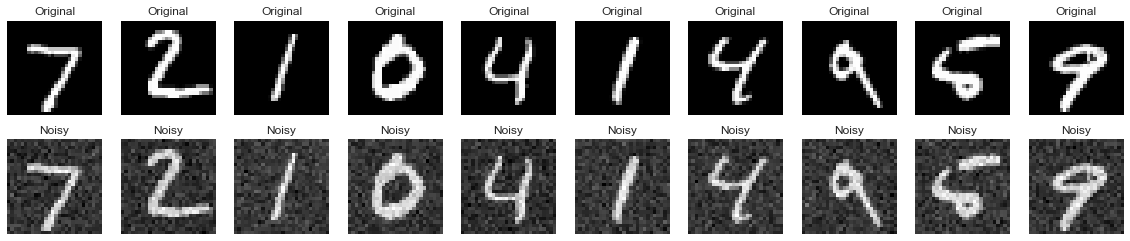

In [47]:
# add noise
noise_factor = 25.0
x_train_noisy = x_train + noise_factor*np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_test_noisy = x_test + noise_factor*np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)

# =========================================================================================================

n = 10  # how many digits we will display

plt.figure(figsize=(20, 4))

for i in range(n):
    
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i])
    plt.gray()
    plt.title('Original')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(x_test_noisy[i])
    plt.gray()
    plt.title('Noisy')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()

In [48]:
# replace the original data with the noisy data before training

x_train = x_train_noisy
x_test = x_test_noisy

In [49]:
x_train = x_train/255
x_test = x_test/255

x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

print(x_train.shape)
print(x_test.shape)

(60000, 784)
(10000, 784)


### Build a Basic AutoEncoder

In [50]:
enc_dim = 32

sz = x_train.shape[1]

theInput = Input(shape=(sz,))
network = Dense(enc_dim, activation='relu')(theInput)
network = Dense(sz, activation='sigmoid')(network)

autoencoder = Model(theInput, network)

In [51]:
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

# cbEarlyStop = EarlyStopping(monitor='val_loss', min_delta=0.00005, patience=3, verbose=0, mode='auto')
# hist = autoencoder.fit(x_train, x_train, epochs=500, batch_size=256, shuffle=True, validation_data=(x_test, x_test), callbacks=[cbEarlyStop])

hist = autoencoder.fit(x_train, x_train, epochs=200, batch_size=256, shuffle=True, validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/200
60000/60000 [==============================] - 5s 86us/step - loss: 0.3561 - val_loss: 0.2718
Epoch 2/200
60000/60000 [==============================] - 5s 81us/step - loss: 0.2651 - val_loss: 0.2549
Epoch 3/200
60000/60000 [==============================] - 4s 70us/step - loss: 0.2435 - val_loss: 0.2303
Epoch 4/200
60000/60000 [==============================] - 4s 73us/step - loss: 0.2222 - val_loss: 0.2121
Epoch 5/200
60000/60000 [==============================] - 5s 75us/step - loss: 0.2068 - val_loss: 0.1988
Epoch 6/200
60000/60000 [==============================] - 5s 78us/step - loss: 0.1953 - val_loss: 0.1890
Epoch 7/200
60000/60000 [==============================] - 5s 79us/step - loss: 0.1866 - val_loss: 0.1813
Epoch 8/200
60000/60000 [==============================] - 5s 81us/step - loss: 0.1794 - val_loss: 0.1747
Epoch 9/200
60000/60000 [==============================] - 5s 81us/step - loss: 0.1732 - val_loss: 0.1

In [52]:
denoisingAutoencoder = pk.dump((autoencoder, hist), open('denoisingAutoencoder.pk', 'wb'))

autoencoder, hist = pk.load(open('denoisingAutoencoder.pk', 'rb'))

In [53]:
encoderInput = Input(shape=(sz,))
encoderLayers = autoencoder.layers[1](encoderInput)
encoder = Model(encoderInput, encoderLayers)

In [54]:
decoderInput = Input(shape=(enc_dim,))
decoderOutput = autoencoder.layers[-1](decoderInput)
decoder = Model(decoderInput, decoderOutput)

In [55]:
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

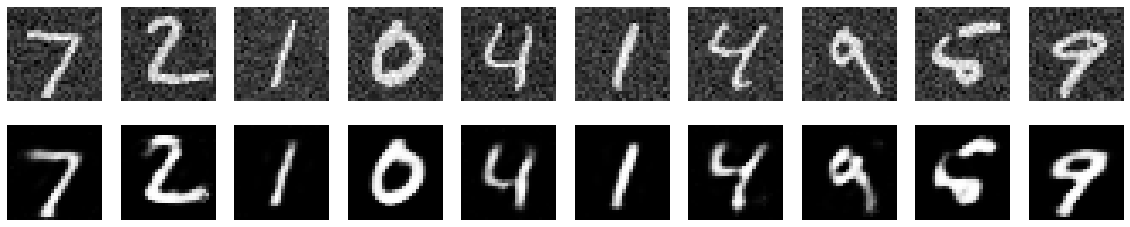

In [56]:
n = 10  # how many digits we will display

sz = data['x_train'].shape[1]

plt.figure(figsize=(20, 4))

for i in range(n):
    
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(sz, sz))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(sz, sz))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()

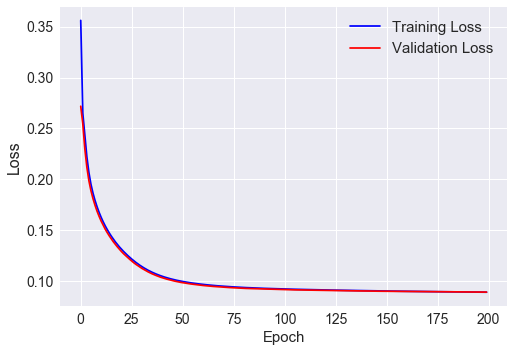

In [57]:
loss = hist.history.get('loss')
val_loss = hist.history.get('val_loss')

plt.plot(loss, 'b')
plt.plot(val_loss, 'r')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Epoch', fontsize=15)
plt.ylabel('Loss', fontsize=16)
plt.legend(['Training Loss', 'Validation Loss'], fontsize=15)
plt.show()